<a href="https://colab.research.google.com/github/SAmeenaHashmi/Self-Taught-Bioinformatics/blob/main/E-coli_Analysis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
with open("/SRR28368091[1].fastq", "r") as f:
    data = f.read()
    '''
    Organism name: Escherichia coli
    URL: https://www.ncbi.nlm.nih.gov/sra/SRX23973193[accn]
    External Id: PNUSAE171872:wgs
    Submitted by: PulseNet Next Generation Subtyping Methods Unit (Pulsenet)
    Bases: 233.5M
    Run: SRR28368091
    '''

In [118]:
import matplotlib.pyplot as plt

The following function reads each line of our file, stores the reads and quality scores in the seq and qual variables respectively, and strips trailing whitespace from two of the lines.

In [92]:
def readFastq(filename):
    sequences = []
    qualities = []
    with open(filename) as fh:
        while True:
            fh.readline() # read tag line but skip
            seq = fh.readline().rstrip() # read base sequence, strip off trailing space
            fh.readline() # read but skip placeholder line
            qual = fh.readline().rstrip() #read base quality line
            if len(seq) == 0: #to check if program has reached file end
                break
            sequences.append(seq) #append values to list
            qualities.append(qual)
    return sequences, qualities
seqs, quals = readFastq('/SRR28368091[1].fastq') #run the function

In [95]:
print(seqs[:10]) #to check if program read correctly

['TGATTACGCTGATTCTGGTGTTTGGCGTTGGCAACGCACTGGTCCATATTTTATCGAGCTTTAATTTACTGCCGGTGTATCAGTAATCAGCGGTGCCTTATCCGACATTTCTGCTGCCTACACAATGCCTGATGCGCTTCGCTTATCAGGG', 'ACACATCGACATCCAGTTTCTCTTTAGCGGTGTCGATACCGATATAATGAAGTTCATGTTCCATAGTGAAACCAACCTTGCAAATACGGATTACCGGGAAAACCGGTCCATGATACTGTCCGGTTTATCACTTTGGGAGAAAGGCAGTCCG', 'ACCTGATAAGCGAAGCGCATCAGGCATTGTGTAGGCAGCAGAAATGTCGGATAAGGCACCGCTGATTACTGATACACCGGCAGTAAATTAAAGCTCGATAAAATATGGACCAGTGCGTTGCCAACGCCAAACACCAGAATCAGCGTAATCA', 'ACTCAGCCCTGGGGCGCTTGAAAACGGCATTGCTGACCTTTGCCCCGCCTGTTGTGGGTGGTCTACTGTTCCCGAACGGATTCCTGTACGCCATTGGTTATGCTGGTTTAGCAGCTACCATCTGGGCGGCAAATGTTCCGGCGCTGTTAG', 'GTGTTAGCGAATTTTTTGGTGCGATGACGACCATCAGGACGCAACACATCGACATCCAGTTTCTCTTTAGCGGTGTCGATACCGATATAATGAAGTTCATGTTCCATAGTGAAACCAACCTTGCAAATACGGATTACCGGGAAAACCGGT', 'GATTACGCTGATTCTGGTGTTTGGCGTTGGCAACGCACTGGTCCATATTTTATCGAGCTTTAATTTACTGCCGGTGTATCAGTAATCAGCGGTGCCTTATCCGACATTTCTGCTGCCTACACAATGCCTGATGCGCTTCGCTTATCAGGT', 'GACCTGATAAGCGAAGCGCATCAGGCATTGTGTAGGCAGCAGAAATGTCGGATAAGGCACCGCTGATTACT

In [97]:
print(quals[:10]) #same but for quality reads

['FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF::FFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFF:', 'FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFF:FFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFF:FFFFFFF,FFFF,,FFFFFFF,FFFFFFFFFFF:FFFFF,', 'FFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFF:FF:FFFFFFFFF:FFFFF:FFFFFFFFFFF:F::FFF,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFF:FFFFFFF,FFFFFFF:FF::F', 'FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,FF:,FFFFFFFFFFFFF', 'FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFF', 'FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFF:FFFFFFF', 'FFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF

The previous results match the information in the file. The program has read the file correctly. Next, we will examine the quality scores of this dataset.

In [119]:
def phred33ToQ(qual): #function to convert phred33 encoded value to quality scores
    return ord(qual) - 33

In [114]:
phred33ToQ('F')

37

As an example, a phredd33 value of F corresponds to a quality score of 31.

In [120]:
def createHistogram(qualityStrings): # Create a histogram of quality scores
    hist = [0]*50
    for read in qualityStrings:
        for phred in read:
            q = phred33ToQ(phred) #first convert to quality score
            hist[q] += 1 #next in the loop
    return hist
h = createHist(quals)
print(h)

[0, 0, 2698, 0, 0, 0, 0, 0, 0, 0, 0, 2243824, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3765341, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 59755738, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


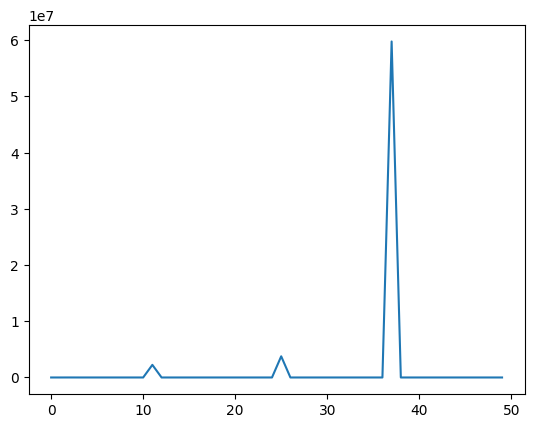

In [124]:
# Plot the histogram
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(len(h)), h) # x-values represents the quality scores, y values represent the number of bases with that score,
plt.show()

In this graph, we can see that about 6e7 bases have a quality score of 37. [According to Illumina,](https://help.basespace.illumina.com/files-used-by-basespace/quality-scores) which is the source of our sequence, a quality score of 30 indicates an error probability of 0.001. At a score of 37, our error probability is even lower.

The trailing behind as the next most common quality score is 25, and then 11. This graph corresponds to the quality graph that Illumina provided, shown below. 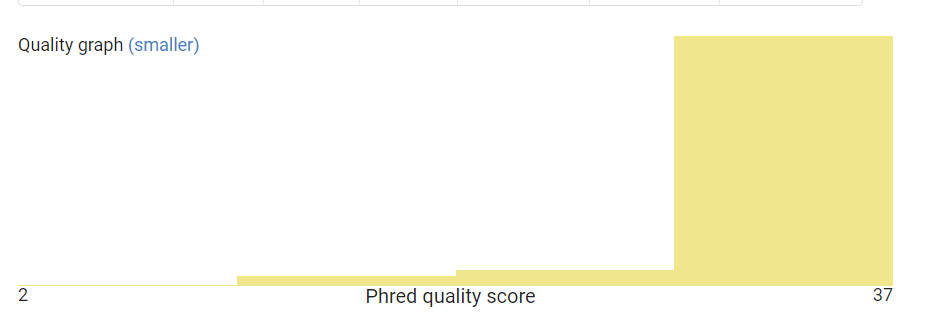

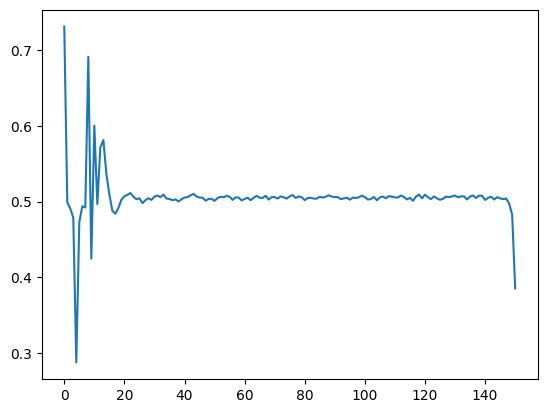

In [127]:
def findGCByPos(reads):
    ''' Find the GC ratio at each position in the read '''
    # monitor Gc and total number of bases
    gc = [0] * 151 #151 one more than the length of each read
    totals = [0] * 151

    for read in reads: #read loop
        for i in range(len(read)): #base loop
            if read[i] == 'C' or read[i] == 'G':
                gc[i] += 1
            totals[i] += 1 #for total bases, increment in all cases
    # divide GC by total for average at each position
    for i in range(len(gc)):
        if totals[i] > 0: #to avoid dividing by zero
            gc[i] /= float(totals[i])
    return gc

gc = findGCByPos(seqs)
plt.plot(range(len(gc)), gc)
plt.show()

The generated graph depicts the average GC content across each position in the DNA sequences. For the most part, the GC content stays consistently just slightly above 50% of the sequences. There is wide variation in the initial positions of each read, ranging from under 0.3 to over 0.7.

This is corroborated by the source of the data, cited above. It states the GC content is 50.6%.

Next is a short function to count the number of each base in this genome.

In [67]:
import collections
count = collections.Counter() #create a counter
for seq in seqs: #for each sequence in our sequences list
    count.update(seq) #update counter
count

Counter({'T': 1017286, 'G': 1076887, 'A': 1011918, 'C': 1064184, 'N': 186})

These results corroborate the previous graph. We can see that the total GC content just slightly exceeds the AT content. The absolute difference between the AT and GC content is 111867.